# CM4AI Community Detection Tutorial

In graph theory, terms like "communities," "clusters," "groups," and "modules" are often used interchangeably to describe subsets of nodes that are densely connected internally and sparsely connected to the rest of the network. This concept is central to community detection, which aims to identify such structures within graphs. Detecting these communities is crucial for understanding the organization and function of complex networks, as they often correspond to functional units within the system. 

Various algorithms have been developed to detect communities in networks. For instance, the Girvan–Newman algorithm identifies edges that lie between communities and removes them to reveal the community structure. Another popular method is modularity maximization, which searches for divisions of a network that have a high modularity score, indicating a strong community structure.

In this tutorial we will walk through how to perform community detection in a simple graph with three communities.

Along the way, we will learn about different metrics that are commonly used in Network Analysis which are related to this task. 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import community as community_louvain

## A Basic Graph with Three Communities

Let's start by drawing a simple graph and visually/subjectively deciding how many 'communities' we think there are. And for the sake of simplicity, lets make the decision to analyze this graph in a way where each node is assigned to a single, distinct community (non-ovelapping community detection).

In [2]:
def create_original_graph():
    G = nx.Graph()
    G.add_edges_from([[1,2], [2,3], [1,3], [1,4], [1,5], [3,5],
                  [6,7], [7,8], [8,9], [6,9], [6,8], [7,9],
                  [10,11], [11,12], [10,12],
                  [9,12], [2,7]])
    return G

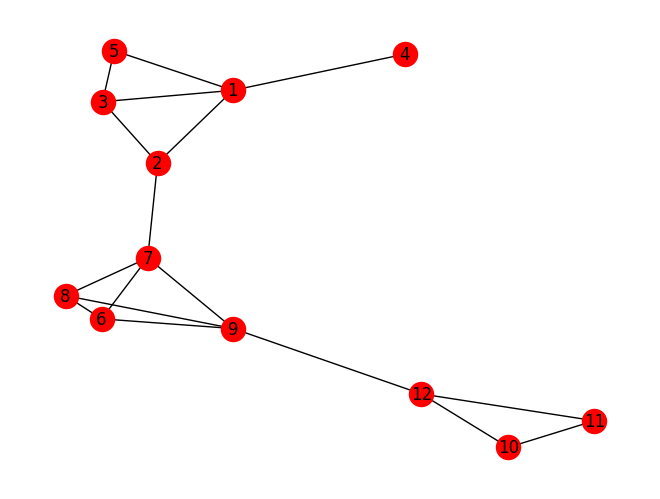

In [3]:
G = create_original_graph()
nx.draw(G, with_labels=True, node_color='r')

Most might argue there are three communities here (although some might argue that 4 is it's own community). 

Let's say there are <u>three</u> 'communities' in this graph.

So, how do we arrive at 'three communities' using a mathematical/algorithmic process?

Let's go through one method called the <u>Girvan-Newman Algorithm</u>. 

The first step is to calculate some metrics that help characterize the edges in this network. 

This is often done by using the general concept of centrality, which aims to quantify the “importance” of vertices or edges within a graph.

<br>
<br>
<br>


## <u>Edge Betweenness Centrality (EBC)</u> 

EBC asks the question, for every pair of nodes in the network, how many of the shortest paths between those nodes pass through a given edge. Stated a second way, it is a measure of the importance of an edge in a graph, calculated as the number of shortest paths between pairs of nodes that pass through that edge. It helps identify critical connections in networks.

Intuitively, an edge with high betweenness is "important" because it frequently appears in shortest paths connecting different vertices in the graph.

So, if we calculate for all edges, which would be the most important do you think?

In [4]:
edge_centrality_G = nx.edge_betweenness_centrality(G)

sorted_by_values = dict(sorted(edge_centrality_G.items(), key=lambda x: x[1], reverse=True))

for edge, centrality in sorted_by_values.items():
    print(f"{edge}: {centrality}")

(2, 7): 0.5303030303030303
(9, 12): 0.4090909090909091
(7, 9): 0.36363636363636365
(1, 2): 0.30303030303030304
(2, 3): 0.18181818181818182
(1, 4): 0.16666666666666669
(10, 12): 0.15151515151515152
(11, 12): 0.15151515151515152
(1, 5): 0.09090909090909091
(6, 7): 0.09090909090909091
(7, 8): 0.09090909090909091
(3, 5): 0.07575757575757576
(6, 9): 0.06060606060606061
(8, 9): 0.06060606060606061
(1, 3): 0.030303030303030304
(6, 8): 0.015151515151515152
(10, 11): 0.015151515151515152


So, [2,7] is the most 'important'

Let's manually calculate edge betweenness for [2,7].
<br>
<br>
<br>
<br>

#### <u> Manually Calculate Edge Betweenness</u>

Remember, EBC is a measure of how many shortest paths (between all pairs of vertices) go through a particular edge. 

$$ b(e) = \sum_{s < t} \frac{\sigma_{s,t}(e)}{\sigma_{s,t}} $$

Where:

- $\sigma_{s,t}(e)$ is the number of those shortest paths that pass through the edge $e$.
- $\sigma_{s,t}$ denotes the total number of shortest paths between vertices $s$ and $t$.
- The summation $\sum_{s < t}$ is taken over all pairs of distinct vertices $s$ and $t$. 

For undirected graphs, it is common to sum over $s < t$ (instead of $s \neq t$) to avoid double-counting paths. The $s < t$ loops over every pair of distinct nodes in the graph exactly once rather than summing over both $(s,t)$ and $(t,s)$. This is purely a notational convenience for an undirected graph and ensures that every node pair is included **exactly once**, avoiding double-counting.

<br>
<br>
<br>

So what would $\sigma_{8,1}({2,7})$ be in the graph below?

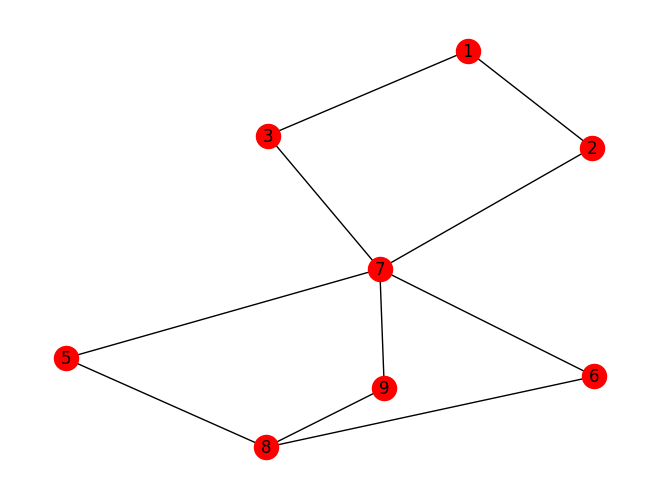

In [5]:
G3 = nx.Graph()
G3.add_edges_from([
    (1, 2), (1, 3),   # Connect 1 -> {2, 3}
    (2, 7), (3, 7),   # Connect {2,3} -> 7
    (7, 5), (7, 6), (7, 9),  # Connect 7 -> {5,6,9}
    (5, 8), (6, 8), (9, 8)   # Connect {5,6,9} -> 8
])
nx.draw(G3, with_labels=True, node_color='r')

all shortest paths from 1 to 8 have length 4, and exactly 6 such paths exist.

Hence, $\sigma_{1,8} = 6$

When we then consider the number of 'shortest paths' from 1 to 8 that pass through the edge [2,7], this would be $\sigma_{1,8}({2,7}) = 3$, giving us a 3/6 fraction for the (1,8) node pair.

Then we do this for all pairs of nodes, and sum all of these fractions with the $s < t$ constraint. 

<br>
<br>

In the originally proposed graph we can use some shortcuts.

Calculate the total number of possible node pairs in this network. Given that there are 12 nodes and we're looking for pairs (i.e., 2), we can use the '12 choose 2' calculation, simplified here:

  $$ \frac{12!}{2!(12-2)!} = 66 $$


In [6]:
total_pairs = (12*11)/2
total_pairs

66.0

In [7]:
# Then find the shortest paths for every pair and determine
# for every 'shortest path' which go through [2,7].
# For this graph we can calculate this via a shortcut by multiplying 
# by the number of nodes on either side of the [2,7] edge.
number_of_nodes_passing_through = 5*7
number_of_nodes_passing_through
 

35

So, 35 pairs of nodes in this network, rely on [2,7] on their shortest path to each other. 

In [8]:
# If we divide these two numbers we get the edge betweenness
print(f"Edge Betweenness Centrality for edge [2, 7] in G by nx: {round(edge_centrality_G.get((2,7)),4)}")
print(f"Edge Betweenness Centrality for edge [2, 7] in G by manual: {round((number_of_nodes_passing_through / total_pairs),4)}")


Edge Betweenness Centrality for edge [2, 7] in G by nx: 0.5303
Edge Betweenness Centrality for edge [2, 7] in G by manual: 0.5303


So, [2,7] is the most 'important' as measured by this metric. 

But as a thought exercise, how could we decrease the centrality of that edge?

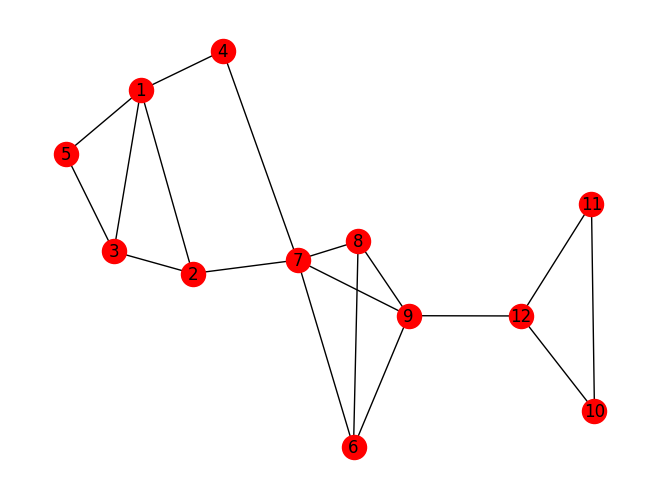

In [9]:
# Add a path for 'the dangler' over to node 2 that would make it's shortest path not use the [2,7] edge
G2 = nx.Graph()
G2.add_edges_from([[1,2], [2,3], [1,3], [1,4], [1,5], [3,5],
                  [6,7], [7,8], [8,9], [6,9], [6,8], [7,9],
                  [10,11], [11,12], [10,12],
                  [9,12], [2,7], [4,7]])
nx.draw(G2, with_labels=True, node_color='r')

Here, we have added an edge between node 4 (i.e., 'the dangler') and node 7. In this network, the shortest path from 4 to 7 is no longer through the [2,7] edge. So the [2,7] calculation for edge betweenness becomes this:

In [10]:
edge_centrality_G2 = nx.edge_betweenness_centrality(G2)
print(f"Edge Betweenness Centrality for edge [2, 7] in G: {round(edge_centrality_G.get((2,7)),4)}")
print(f"Edge Betweenness Centrality for edge [2, 7] in G2: {round(edge_centrality_G2.get((2,7)),4)}")

Edge Betweenness Centrality for edge [2, 7] in G: 0.5303
Edge Betweenness Centrality for edge [2, 7] in G2: 0.3434


## <u>Girvan-Newman Algorithm</u>

Now that we have the EBC for all of the edges, how does the Girvan-Newman Algorithm use that to find communities?

Look for the edge that has the highest EBC and delete that edge. 

Recompute the EBC, and repeat. 

This is liberating communities from the network, so that hopefully at the end we have all of the communities by themselves. 

The trick is to know how many 'deletions' to do. 

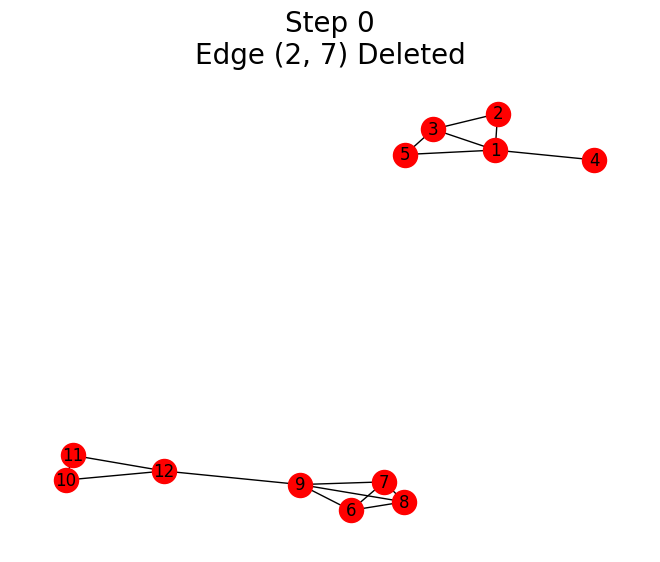

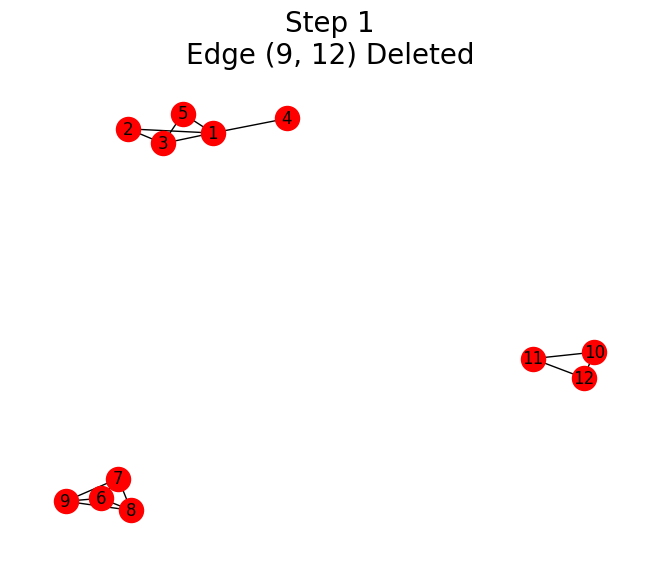

In [11]:
num_iterations = 2

G = create_original_graph()

for i in range(num_iterations):
    tmp_ebc = nx.edge_betweenness_centrality(G).items()
    edge_to_delete = sorted(tmp_ebc, key=lambda pair: -pair[1])[0][0]
    
    G.remove_edge(*edge_to_delete)
    
    nx.draw(G, with_labels=True, node_color='r')
    plt.title('Step %s\nEdge %s Deleted'%(i, edge_to_delete), fontsize=20)
    
    plt.show()

In [12]:
# --- Girvan-Newman Community Detection ---
# girvan_newman returns an iterator of partitions (each partition is a tuple of sets of nodes).
# The first `next(...)` will give the first split (2 communities). 
# You can keep calling `next(...)` to get more finely split communities.
G = create_original_graph()

gn_partitions = nx.community.girvan_newman(G)
first_level_partition = next(gn_partitions)   # This is the partition with the first split
num_communities_gn = len(first_level_partition)
print("Number of communities (Girvan-Newman, first split):", num_communities_gn)

Number of communities (Girvan-Newman, first split): 2


As you can see, the crux of using Girvan-Newman is deciding when to stop splitting up the graph. 

You typically track a quality measure (often modularity) at each step and pick the partition that yields the best score (e.g., the highest modularity). In other words, you have to decide the “optimal cut” or watch when the modularity peaks.

However, it can be computationally expensive for large networks, and you need to determine the best stopping point manually (by checking the modularity changes after each removal, or following some heuristic).

There are some algorithms where the decision of **when to stop** is baked into the algorithm and in a way that optimizes performance. 

But, before we do that, we need to understand another metric commonly used in Network Analysis: **<u>Modularity</u>**

<br>
<br>

---

## Modularity (Q)

### Intuitive Understanding of Modularity

Measures how well a graph is partitioned into communities. 

$Q \propto \sum_{s \in S} \Big[ (\text{number of edges within group } s) \;-\; (\text{number of EXPECTED edges within group } s) \Big]$

Intuitively, $Q$ is proporational to the summation over all the communities where for every community, we ask how many edges are there between the members of the group $s$, minus how many edges would I expect between the nodes of group $s$ in some random null model. 

And if the group $s$ connections are more than what we would expect in a random, then we have found a significant cluster.

The total modularity of the network is the sum of the modularity score for each individual cluster/community.

So, we need to figure a way to calculate the number of 'expected connections' within a community.
<br>
<br>

### Configuration Model

The Configuration Model is a random graph model that preserves the degree distribution of the original graph. 

It generates a network by randomly connecting nodes while ensuring that each node's degree matches its specified value, thereby maintaining the overall <u>degree distribution</u> of the network. This model provides a more realistic baseline for expected edges in networks with heterogeneous degree distributions.

The expected number of edges between two nodes $i $ and $j$ in the Configuration Model is given by:

$\text{Expected edges between } i \text{ and } j = \frac{k_i k_j}{2m}$

where:
- $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$,
- $2m$ is the total number of edges in the network.

<br>
<br>


### Modularity Equation Breakdown

$Q(G, S) = \frac{1}{2m} \sum_{s \in S} \sum_{i \in s} \sum_{j \in s} \left( A_{ij} - \frac{k_i k_j}{2m} \right)$

Modularity a set of groups $S$ in graph $G$ is a sum over all the paris of nodes in the group, where we look at $A_{ij}$ to determine if that pair of nodes is connected in the group and then for every pair we calculate the expected number of edges between a pair of nodes using the Configuration Model as our null model. So we are saying what is the real number of edges, minus the expected number of edges, for all the pairs of nodes within a given group $s$, and now i sum this over all the groups $s$ into $S$. And $A_{ij}$ is 1 but if connection is 0. 

$\frac{1}{2m}$ is a normalizing constant that keeps $Q$ in the range of -1 to 1.
- Where if the modularity $Q$ for a given set of partitions $S$ is "high" (i.e., >0.5), the graph has significant community structure

<br>
<br>

### Why is Higher Modularity "Better"?

Modularity measures how well nodes within a single community connect to each other relative to how they connect to nodes outside that community. A higher modularity for a given community means:

- More internal cohesion: Most edges are between the nodes inside the community.
- Less external linkage: There are fewer edges connecting those nodes to other parts of the network.

If one finds that the summation of modularities is *"high"* across a set of partitions $S$ across a given graph $G$, the algorithm has likely done a good job at identifiying self-contained, distinct, or meaningful clusters within the larger network. 

The overall idea being that we have done a good job of identifing communities if we maximize modularity

So then this would become the target of an objective function that we use formulate as a kind of optimization problem for community detection - i.e., we will try to maximize $Q(G,S)$, and to do this we will use the <u>Louvain Algorithm</u>

<br>
<br>

-----

## The Louvain Algorithm

The **Louvain algorithm** is a popular method for detecting communities with high modularity scores $Q$ in large networks due to its **speed** and **scalability**. 

- *Greedy* algorithm for community detection
  - Refers to a strategy where decisions are made step-by-step, choosing the locally optimal solution at each step in the hope that this leads to a globally optimal solution.
- Supports weighted graphs
- Supports hierarchical clustering

<br>

It operates in two major phases that repeat iteratively:

1. **Local Modularity Optimization**  
   - Start with each node $i$ in its own community.  
   - For each node $i$, consider moving it to the community of one of its neighbors.  
   - Calculate the change in modularity $\Delta Q$ for this move. If $\Delta Q$ is **positive**, move node $i$ to that neighbor’s community.

2. **Community Aggregation**  
   - Once no more improvements can be made by local moves, **aggregate** each community into a “super-node.”  
   - Replace each entire community with a single super-node, and build a smaller, coarser network.  
   - Repeat Phase 1 on this aggregated network until no further modularity improvement is possible.

<br>

### Modularity and the Gain $\Delta Q$

In Louvain, the **modularity** $Q$ of a partition is commonly defined as:

$$
Q = \frac{1}{2m} \sum_{i,j} \biggl(A_{ij} - \frac{k_i \, k_j}{2m}\biggr) \delta(c_i, c_j),
$$

where:

- $A_{ij}$ is the adjacency matrix (1 if there is an edge between $i$ and $j$, or the weight if weighted).  
- $k_i$ is the degree (or sum of edge weights) of node $i$.  
- $m$ is the total number of edges (or total edge weight).  
- $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community, and 0 otherwise.

When **moving** a single node $i$ from its current community to a neighboring community $C$, the **change in modularity** $\Delta Q$ can be computed (in one simplified form) as:

$$
\Delta Q \approx \frac{k_i^{\text{in},C} - k_i \frac{S_C}{2m}}{2m},
$$

where:

- $k_i^{\text{in},C}$ is the sum of the weights of edges from node $i$ to the nodes in community $C$.  
- $k_i$ is the sum of the weights of edges from node $i$ to **all** other nodes.  
- $S_C$ is the sum of the degrees (edge weights) of the nodes in community $C$.  
- $m$ is the total edge weight in the network.

If $\Delta Q > 0$, moving $i$ to $C$ **increases** overall modularity.

<br>
<br>

---

### Why Is Louvain Faster Than Girvan–Newman?

1. **Local, Greedy Optimizations**  
   - Louvain updates communities by checking small, local moves for each node $i$.  
   - Girvan–Newman iteratively **removes the highest-betweenness edge** and recalculates global betweenness each time, which is computationally expensive.

2. **Hierarchical (Multi-Level) Approach**  
   - After no more local moves can improve modularity, Louvain **collapses** each community into a super-node and repeats the process on a smaller graph.  
   - This reduction significantly speeds up subsequent iterations.

3. **No Repeated Global Betweenness Computation**  
   - Girvan–Newman requires recomputing **edge betweenness** multiple times, which is costly ($O(n \times m)$ or worse).  
   - Louvain only needs to compute **local gains** in modularity ($\Delta Q$) when moving nodes.

4. **Early Termination**  
   - Louvain naturally **stops** once modularity cannot be improved any further.  
   - No need for exhaustive searches or repeated cuts of the graph.

As a result, **Louvain’s greedy, multi-level collapsing** approach scales well to large networks, making it **significantly faster** in practice than Girvan–Newman for community detection.


In [13]:
G = create_original_graph()

# --- Louvain Community Detection ---
# best_partition returns a dict of node -> community ID
louvain_partition = community_louvain.best_partition(G)
num_communities_louvain = len(set(louvain_partition.values()))
print("Number of communities (Louvain):", num_communities_louvain)

Number of communities (Louvain): 3
